## Import Libraries

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import random

from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from skimage import exposure
from scipy import ndimage
from skimage.transform import resize
import cv2

import nibabel as nib
from nilearn import datasets
from nilearn import plotting

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model



tfd = tfp.distributions
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

/usr/local/lib/python3.6/dist-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


TFP Version 0.12.1
TF  Version 2.4.0


## Load Dataset

In [2]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
OUTPUT_DIR = "/tf/notebooks/avci/xAI_3D/callbacks/3D_CNN_ONTRAM_stroke_nostroke_datapreprocessed_Loran/"


/tf/notebooks/avci/xAI_3D/usz_notebooks


In [3]:
with h5py.File(IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', "r") as h5:
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]
    
X_in = np.expand_dims(X_in, axis = 4)
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

(439, 128, 128, 28, 1) -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


## Preprocess Data

In [4]:
def normalize(volume):
    """Normalize the volume"""
    min = np.min(volume)
    max = np.max(volume) 
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

X_in = np.array([normalize(img) for img in X_in])
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

(439, 128, 128, 28, 1) 0.0 1.0 0.06382954 0.111165084


In [5]:
dat = pd.read_csv('/tf/notebooks/avci/xAI_3D/data/baseline_data_zurich_prepared0.csv', sep=";")

In [6]:
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], X_in.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
X_tab.shape

(414, 13)

In [7]:
age = X_tab[:,0]
age = np.float32(age)
log_age = np.log(age)
mu,sd = np.mean(log_age), np.std(log_age)
print(mu,sd)
z_age = (log_age -mu) /sd ### np.exp(z_age*sd+mu)

4.1790805 0.2768624


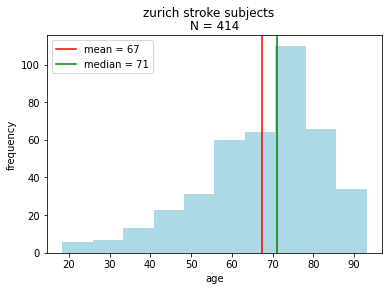

In [8]:
plt.hist(age, color = "lightblue")
plt.xlabel('age')
plt.ylabel('frequency')
plt.title(str('N = ' + str(len(age))))
plt.suptitle('zurich stroke subjects')
plt.axvline(np.mean(age), color = 'r', label = str("mean = "+ str(int(np.mean(age)))))
plt.axvline(np.median(age), color = 'g', label =  str("median = "+ str(int(np.median(age)))))
plt.legend(loc='upper left')
plt.show()

In [9]:
# Split data into training set and test set

X = np.squeeze(X)
X = np.float32(X)

rng = check_random_state(42)
X_train, X_test, y_train, y_test = train_test_split(X, z_age, train_size=0.8, random_state=rng)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=rng)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(331, 128, 128, 28) (42, 128, 128, 28) (41, 128, 128, 28)
(331,) (42,) (41,)


## Build Model

In [10]:
# model
initializer = keras.initializers.he_normal(seed = 2202)

inputs = keras.Input((128, 128, 28,1))
x = layers.BatchNormalization()(inputs)

# conv block 0
x = layers.Convolution3D(16, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(16, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# conv block 1
x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# conv block 2
x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# conv block 3
x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

# flat block
x = layers.GlobalAveragePooling3D()(x) 
x = layers.BatchNormalization(center=True, scale=True)(x)

x = layers.Dense(128, activation = 'relu')(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(units=1)(x)

# Define the model.
model_3d = Model(inputs=inputs, outputs=out, name = "cnn_3d_")
model_3d.summary()

Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 28, 1)   4         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 28, 16)  448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 28, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 128, 128, 28, 16)  6928      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 28, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 14, 16)    0   

## Augment 3D Data

In [11]:
#aumentation functions

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


@tf.function
def zoom(volume):
    """Rotate the volume by a few degrees"""

    def random_zoom3d(X_im, min_zoom = 0.7 , max_zoom = 1.4):
        z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
        zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
        volume = ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)
        return volume

    augmented_volume = tf.numpy_function(random_zoom3d, [volume], tf.float32)
    return augmented_volume


@tf.function
def gauss(volume):
    """Rotate the volume by a few degrees"""

    def random_gaussianfilter3d(X_im, sigma_max=0.2):
        sigma = np.random.uniform(0, sigma_max)
        volume = ndimage.gaussian_filter(X_im, sigma, mode = "nearest")
        return volume

    augmented_volume = tf.numpy_function(random_gaussianfilter3d, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = zoom(volume)
    volume = gauss(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



In [12]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 16

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


## Run Model

In [13]:
#compile
model_3d.compile(
    loss="mse",
    ##optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

from datetime import datetime
current_time = datetime.now().strftime("%y-%m-%d-%H_%M_%S")
model_name = "weights/3d_age_reg_usz.hf" + str(current_time) + ".h5"

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=150)


In [14]:
# Train the model, doing validation at the end of each epoch
epochs = 500
train= False

if train:
    hist = model_3d.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
)
    
if train:
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylim(0,3)
    plt.show()


## Model Evaluation

In [16]:
model_name = 'weights/3d_age_reg_usz.hf22-05-12-17_05_47.h5'#5.49 MAE
model_3d.load_weights(model_name)
y = np.exp(y_test  *sd + mu)
preds_log = model_3d.predict(X_test)
y_pred = np.exp(preds_log*sd + mu)
mae = np.median(abs(np.squeeze(y_pred) - y))
print('CNN MAE: ', np.round(mae,2))
print('Unconditional MAE', np.round(np.mean(abs(np.mean(age) - y)),2))

CNN MAE:  5.49
Unconditional MAE 11.22


# Grad CAM

In [17]:

def grad_cam_3d(img, model_3d, layer):
    
    # Create a graph that outputs target convolution and output
    grad_model = tf.keras.models.Model([model_3d.inputs], [model_3d.get_layer(layer).output, model_3d.output])
    
    ###--Compute GRADIENT
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)    
        loss = predictions[0][0]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Build a ponderated map of filters according to gradients importance
    cam = np.zeros(output.shape[0:3], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, :, :, index]

    capi=resize(cam,(img.shape[1:]))
    capi = np.maximum(capi,0)
    heatmap = (capi - capi.min()) / (capi.max() - capi.min())
    resized_img = img.reshape(img.shape[1:])
    
    return heatmap, resized_img



## Avg. Grad-CAM

In [18]:
h_l = []
i_l = []
for j in range(len(y_train)):
    
    heatmap, resized_img = grad_cam_3d(img = X_train[j:j+1], model_3d = model_3d , layer = model_3d.layers[-9].name)
    h_l.append(heatmap)
    i_l.append(resized_img)


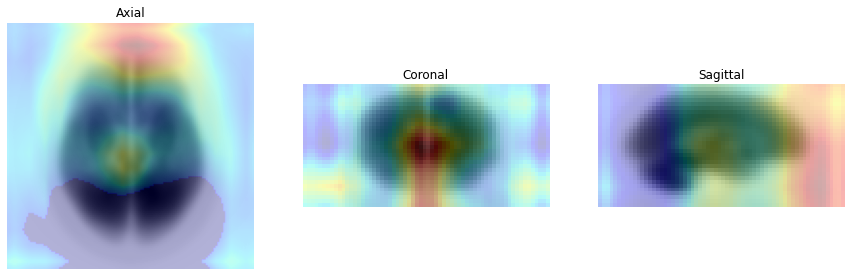

In [19]:

plt.figure(figsize = (15,50))
th = 0.2

dsize = (128,128)
dsize = (64,32)

# axial average
plt.subplot(1,3,1)
plt.title('Axial')
axial = np.mean(np.array(h_l), (0,3))
th = np.max((np.mean(np.array(h_l), (0,3))))*th
axial[axial < th ] = 0
plt.imshow(np.negative(np.mean(np.array(i_l), (0,3))), cmap='gray')
plt.imshow(axial, alpha=0.3,cmap="jet")
plt.axis('off')

# coronal average
plt.subplot(1,3,2)
plt.title('Coronal')
coronal = np.mean(np.array(h_l), (0,1))
th = np.max((np.mean(np.array(h_l), (0,1))))*th
coronal[coronal < th ] = 0
plt.imshow(cv2.resize(np.negative(np.rot90(np.mean(np.array(i_l), (0,1)))), dsize=dsize, interpolation=cv2.INTER_LINEAR), cmap='gray')
plt.imshow(cv2.resize(np.rot90(coronal), dsize= dsize, interpolation=cv2.INTER_LINEAR), alpha=0.3,cmap="jet")
plt.axis('off')

# sagital average
plt.subplot(1,3,3)
plt.title('Sagittal')
sagital = np.mean(np.array(h_l), (0,2))
th = np.max((np.mean(np.array(h_l), (0,2))))*th
sagital[sagital < th ] = 0
plt.imshow(cv2.resize(np.negative(np.fliplr(np.rot90(np.mean(np.array(i_l), (0,2))))), dsize=dsize, interpolation=cv2.INTER_LINEAR), cmap='gray')
plt.imshow(cv2.resize(np.fliplr(np.rot90(sagital)), dsize=dsize, interpolation=cv2.INTER_LINEAR), alpha=0.3,cmap="jet")
plt.axis('off')

plt.show()

## Layer Iteration

conv3d


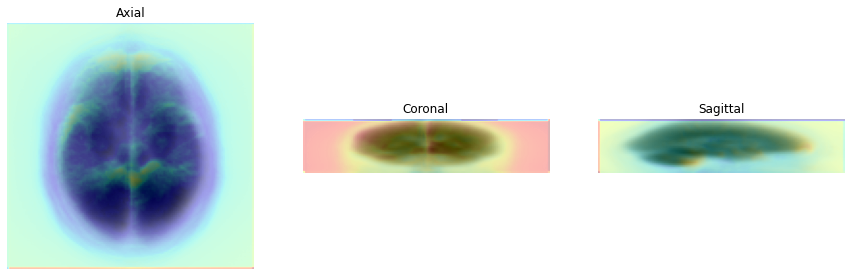

batch_normalization_1


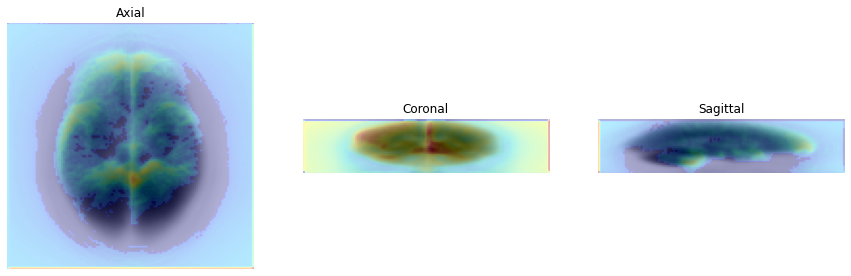

conv3d_1


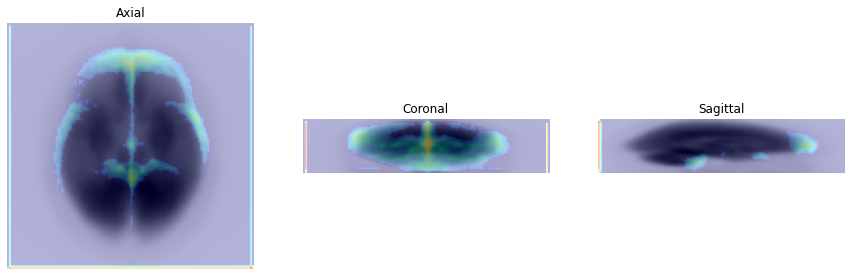

batch_normalization_2


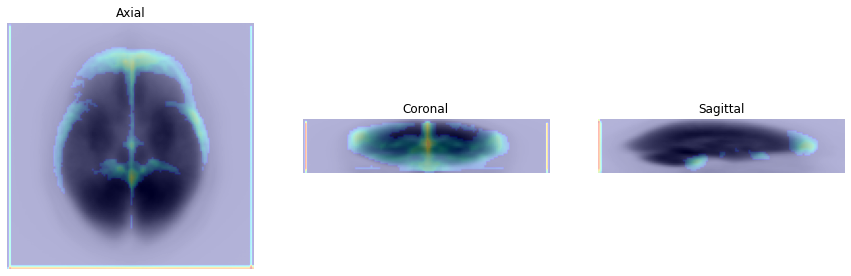

In [ ]:
for i in model_3d.layers[2:-6]:
    layer = i.name
    
    
    h_l = []
    i_l = []
    for j in range(len(y_test)):
        
        heatmap, resized_img = grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = layer)
        h_l.append(heatmap)
        i_l.append(resized_img)
    print(layer)
    plt.figure(figsize = (15,45))
    # axial average
    plt.subplot(1,3,1)
    plt.title('Axial')
    axial = np.mean(np.array(h_l), (0,3))
    th = np.max((np.mean(np.array(h_l), (0,3))))*0.2
    axial[axial < th ] = 0
    plt.imshow(np.negative(np.mean(np.array(i_l), (0,3))), cmap='gray')
    plt.imshow(axial, alpha=0.3,cmap="jet")
    plt.axis('off')
    # coronal average
    plt.subplot(1,3,2)
    plt.title('Coronal')
    coronal = np.mean(np.array(h_l), (0,1))
    th = np.max((np.mean(np.array(h_l), (0,1))))*0.2
    coronal[coronal < th ] = 0
    plt.imshow(np.negative(np.rot90(np.mean(np.array(i_l), (0,1)))), cmap='gray')
    plt.imshow(np.rot90(coronal), alpha=0.3,cmap="jet")
    plt.axis('off')
    # sagital average
    plt.subplot(1,3,3)
    plt.title('Sagittal')
    sagital = np.mean(np.array(h_l), (0,2))
    th = np.max((np.mean(np.array(h_l), (0,2))))*0.2
    sagital[sagital < th ] = 0
    plt.imshow(np.negative(np.fliplr(np.rot90(np.mean(np.array(i_l), (0,2))))), cmap='gray')
    plt.imshow(np.fliplr(np.rot90(sagital)), alpha=0.3,cmap="jet")
    plt.axis('off')
    
    plt.show()
